In [450]:
import pandas as pd 
from nltk.corpus import stopwords
import nltk
import re
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from collections import Counter
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB

In [223]:
#nltk.download('stopwords')

In [224]:
variants = pd.read_csv("training_variants")

In [225]:
variants.head(5)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [226]:
variants["Class"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [227]:
variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [228]:
# The value_counts() function is used to get a Series containing counts of unique values
variants["Gene"].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RRAS2       1
JUN         1
SHQ1        1
INPP4B      1
PAX8        1
Name: Gene, Length: 264, dtype: int64

In [229]:
#data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [230]:
data_text =pd.read_csv("training_text",sep="\|\|",names=["ID","TEXT"],skiprows=1)

<ipython-input-230-6e386e1ad195>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text =pd.read_csv("training_text",sep="\|\|",names=["ID","TEXT"],skiprows=1)


In [231]:
data_text.head(5)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [232]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [233]:
stop_words = set(stopwords.words('english'))

In [234]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [235]:
# Below code will take some time because its huge text (took 4 minute on my 16 GB RAM system), so run it and have a cup of coffee :)
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

<ipython-input-234-677b2ace2022>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text[col][ind] = string


In [236]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


* data_text [col] [index]
* data_text ["TEXT"] [0] : this way can access row 0 of column TEXT

# merge the two dataset 

In [237]:
#merging both gene_variations and text data based on ID
result = pd.merge(variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [238]:
#look for missing valuesisnull().values.any()
# Check if any column has null values 
result.loc[-1] = [1234,np.nan,np.nan,5,np.nan]
del_col = result[result.isnull().any(axis=1)]
del_col

,ID,Gene,Variation,Class,TEXT
1109,1109.0,FANCA,S1088F,1.0,NaN
1277,1277.0,ARID5B,Truncating Mutations,1.0,NaN
1407,1407.0,FGFR3,K508M,6.0,NaN
1639,1639.0,FLT1,Amplification,6.0,NaN
2755,2755.0,BRAF,G596C,7.0,NaN
-1,1234.0,NaN,NaN,5.0,NaN


* Quickly see if either column has any null values
* df.isnull().any()
* Count rows that have any null values
* df.isnull().sum()

In [239]:
# Check if any column has null values 
# Alternative way 
#del_col = del_col.replace(" ", np.nan)  
#del_col
# df = result.replace('     ', np.nan)                   # to get rid of empty values
# nan_values = df[df.isna().any(axis=1)] 
# nan_values 

In [240]:
del_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1109 to -1
Data columns (total 5 columns):
ID           6 non-null float64
Gene         5 non-null object
Variation    5 non-null object
Class        6 non-null float64
TEXT         0 non-null object
dtypes: float64(2), object(3)
memory usage: 288.0+ bytes


In [241]:
# del_col.columns
# result.loc[-1] = [1234,np.nan,np.nan,5,np.nan]
# del_col

In [242]:
# for col in del_col.columns:
#     if "empty" in lower(del_col[col])
x = del_col.columns[del_col.isin([np.nan]).any()]
for item in x:
    print(item)

Gene
Variation
TEXT


In [243]:
del_col = result[result.isnull().any(axis=1)]
del_col

,ID,Gene,Variation,Class,TEXT
1109,1109.0,FANCA,S1088F,1.0,NaN
1277,1277.0,ARID5B,Truncating Mutations,1.0,NaN
1407,1407.0,FGFR3,K508M,6.0,NaN
1639,1639.0,FLT1,Amplification,6.0,NaN
2755,2755.0,BRAF,G596C,7.0,NaN
-1,1234.0,NaN,NaN,5.0,NaN


In [244]:
#def treating_null_values(drop=False,del_col): 
#non-default argument follows default argument
def treating_null_values(result,drop=False):
    # replace space with none
    result = result.replace(" ", np.nan) 
    # get rows where atleast 1 value is null
    del_col = result[result.isnull().any(axis=1)]
    #get column names where atleast 1 value is nan   
    x = list(del_col.columns[del_col.isin([np.nan]).any()])
    # drop default false , if yes drop col with all null values
    delete_list=[]
    if drop:
        for col in x:
            # convert dataframe into pandas series 
            # try to get unique values in the column
            store = del_col[col].squeeze().unique()
            # if all row in a column is nan , then store contain nan
            if pd.isna(store[0]):
                print("Drop Column : ",col)
                delete_list.append(col)
                #result = result.dropna(col)
                # if row dropped remove it from list of column to be modified
                x.remove(col)
    return x,delete_list

returns = treating_null_values(result,drop=True)
returns
#print(returns[1])
#print(type(store[0]))
#check for null value in column 
# print(type(x))
# if pd.isna(store[0]):
#     print("Drop Column",x[0])

Drop Column :  TEXT


(['Gene', 'Variation'], ['TEXT'])

* we want to drop all the rows having missing values in any of the columns colA or colC 
## df = df.dropna ( subset=['colA', 'colC'] )
* can even drop all rows if they’re having missing values in both colA and colB:
## df = df.dropna( subset=['colA', 'colB'], how='all')
## Drop rows with at least N non-missing values
*  drop all the rows that have at least N columns with non- missing values, then you need to specify the thresh argument 
- thresh argument : specifies the number of non-missing values that should be present for each row in order not to be dropped.
- if you want to drop all the columns that have more than one null values, then you need to specify thresh to be 
- len(df.columns) — 1
## df = df.dropna(thresh=len(df.columns)-1)

In [245]:
# def modify_col_null(df,modify_list=[],drop_list=[]):
#     print("inside",modify_list ,drop_list)
# modify_col_null(df,returns[1],returns[0])

In [246]:
# {'Gene': ['Gene', 'Variation'], 'Variation': ['Gene', 'Variation']}
# creating this kind of DS will be useful 
def add_values_in_dict(sample_dict, key_list, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    for key in key_list:
        if key not in sample_dict:
            sample_dict[key] = list()
        sample_dict[key].extend(list_of_values)
    return sample_dict

sample_dict={}
add_values_in_dict(sample_dict,returns[0],['Gene','Variation'])

{'Gene': ['Gene', 'Variation'], 'Variation': ['Gene', 'Variation']}

In [248]:
result = result.dropna ( subset=['Gene', 'Variation'])

In [249]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [251]:
del_col = result[result.isnull().any(axis=1)]
del_col

,ID,Gene,Variation,Class,TEXT


# Creating Training, Test and Validation data
* all spaces in Gene and Variation column to be replaced by _.

In [252]:
result

,ID,Gene,Variation,Class,TEXT
0,0.0,FAM58A,Truncating Mutations,1.0,cyclin dependent kinases cdks regulate variety...
1,1.0,CBL,W802*,2.0,abstract background non small cell lung cancer...
2,2.0,CBL,Q249E,2.0,abstract background non small cell lung cancer...
3,3.0,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4.0,CBL,L399V,4.0,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316.0,RUNX1,D171N,4.0,introduction myelodysplastic syndromes mds het...
3317,3317.0,RUNX1,A122*,1.0,introduction myelodysplastic syndromes mds het...
3318,3318.0,RUNX1,Fusions,1.0,runt related transcription factor 1 gene runx1...
3319,3319.0,RUNX1,R80C,4.0,runx1 aml1 gene frequent target chromosomal tr...


In [253]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [254]:
result

,ID,Gene,Variation,Class,TEXT
0,0.0,FAM58A,Truncating_Mutations,1.0,cyclin dependent kinases cdks regulate variety...
1,1.0,CBL,W802*,2.0,abstract background non small cell lung cancer...
2,2.0,CBL,Q249E,2.0,abstract background non small cell lung cancer...
3,3.0,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4.0,CBL,L399V,4.0,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316.0,RUNX1,D171N,4.0,introduction myelodysplastic syndromes mds het...
3317,3317.0,RUNX1,A122*,1.0,introduction myelodysplastic syndromes mds het...
3318,3318.0,RUNX1,Fusions,1.0,runt related transcription factor 1 gene runx1...
3319,3319.0,RUNX1,R80C,4.0,runx1 aml1 gene frequent target chromosomal tr...


# we can now start our split process in train, test and validation data set.
 by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [257]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [258]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [264]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

In [261]:
train_class_distribution

7.0    609
4.0    439
1.0    363
2.0    289
6.0    176
5.0    155
3.0     57
9.0     24
8.0     12
Name: Class, dtype: int64

# Building a Random model

In [267]:
'''
 since log loss is the accuracy measure for the problem and there is no threshold 
for log loss good model 
we build a random model and compare other models WRT to it 
thus we evaluate our model is good or bad 
'''

'\n since log loss is the accuracy measure for the problem and there is no threshold \nfor log loss good model \nwe build a random model and compare other models WRT to it \nthus we evaluate our model is good or bad \n'

In [281]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]
#-------------------------------
# validating the calculation so that the probability sum = 1
rand_probs = np.random.rand(1,9)
sum(rand_probs)
'''
array([0.15090438, 0.31058949, 0.57305264, 0.079902  , 0.900063  ,
       0.70679603, 0.38556122, 0.77737241, 0.63659891])
'''
sum(sum(rand_probs) )
'''
4.98310313837684
'''
k =(rand_probs/sum(sum(rand_probs) ) )
"""
array([[0.15976714, 0.13078555, 0.08236776, 0.03217746, 0.05158473,
        0.00778152, 0.11440138, 0.22473536, 0.19639909]])
"""
k[0]
"""
array([0.17114048, 0.21528683, 0.15934698, 0.17622461, 0.04681149,
       0.00232496, 0.11860962, 0.09600752, 0.0142475 ])
"""
sum(k[0])
'''
1.0
'''

'\n1.0\n'

In [283]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    # this we are doing to make the sum of probabilities as 1 
    # we validated this calculation in the previous block
    cv_predicted_y[i] = ( (rand_probs/sum(sum(rand_probs) ) )[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.522525704969488


In [285]:
# repeat the same for test error 


In [286]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.4764028868826875


In [287]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([2, 0, 6, 1, 3, 5, 6, 8, 3, 3, 0, 0, 7, 1, 4, 2, 1, 0, 7, 1, 8, 5,
       4, 6, 6, 2, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 5, 8, 6, 7, 8, 6, 6,
       8, 0, 2, 2, 2, 5, 3, 3, 3, 3, 8, 6, 5, 0, 4, 0, 7, 6, 0, 2, 5, 5,
       3, 5, 4, 7, 5, 0, 4, 2, 2, 1, 5, 4, 8, 8, 8, 3, 6, 8, 7, 3, 1, 6,
       1, 1, 5, 5, 6, 4, 4, 1, 1, 4, 4, 4, 4, 3, 5, 7, 7, 4, 3, 5, 1, 2,
       0, 5, 4, 0, 7, 7, 4, 1, 1, 7, 3, 8, 8, 1, 2, 2, 0, 1, 8, 7, 3, 5,
       1, 8, 3, 8, 8, 5, 0, 8, 2, 3, 0, 2, 7, 0, 5, 6, 4, 2, 4, 0, 3, 2,
       2, 3, 2, 3, 5, 4, 4, 5, 5, 8, 1, 6, 3, 5, 5, 1, 1, 2, 7, 5, 1, 3,
       4, 5, 8, 3, 6, 0, 4, 0, 7, 5, 1, 3, 6, 2, 0, 0, 2, 7, 7, 0, 6, 1,
       2, 7, 0, 6, 3, 8, 6, 0, 2, 3, 4, 8, 6, 7, 0, 0, 2, 7, 6, 2, 8, 4,
       8, 5, 3, 0, 2, 2, 0, 0, 8, 5, 3, 0, 1, 6, 3, 7, 6, 1, 0, 4, 7, 2,
       7, 4, 2, 2, 2, 4, 6, 7, 7, 8, 3, 6, 2, 5, 8, 6, 2, 2, 5, 3, 2, 6,
       4, 1, 0, 6, 8, 3, 0, 3, 7, 4, 8, 6, 1, 3, 8, 8, 0, 6, 7, 6, 1, 8,
       7, 1, 7, 1, 4, 5, 1, 5, 5, 1, 1, 8, 2, 3, 2,

In [289]:
#see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.
predicted_y = predicted_y + 1

# Confusion Matrix

In [291]:
C = confusion_matrix(y_test, predicted_y)

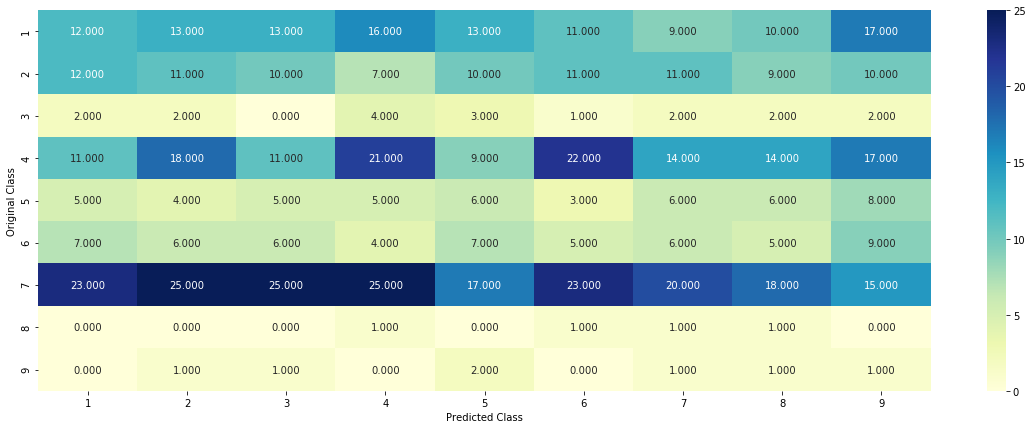

In [298]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

* we see the diagonal value are not high , the model is obviously not good 

In [299]:
C

array([[12, 13, 13, 16, 13, 11,  9, 10, 17],
       [12, 11, 10,  7, 10, 11, 11,  9, 10],
       [ 2,  2,  0,  4,  3,  1,  2,  2,  2],
       [11, 18, 11, 21,  9, 22, 14, 14, 17],
       [ 5,  4,  5,  5,  6,  3,  6,  6,  8],
       [ 7,  6,  6,  4,  7,  5,  6,  5,  9],
       [23, 25, 25, 25, 17, 23, 20, 18, 15],
       [ 0,  0,  0,  1,  0,  1,  1,  1,  0],
       [ 0,  1,  1,  0,  2,  0,  1,  1,  1]], dtype=int64)

In [302]:
C.sum(axis=0)
# vertical sum 
# array([72, 80, 71, 83, 67, 77, 70, 66, 79], dtype=int64)
#.sum(axis=1)
# horizontal sum
#  array([114,  91,  18, 137,  48,  55, 191,   4,   7], dtype=int64)

array([72, 80, 71, 83, 67, 77, 70, 66, 79], dtype=int64)

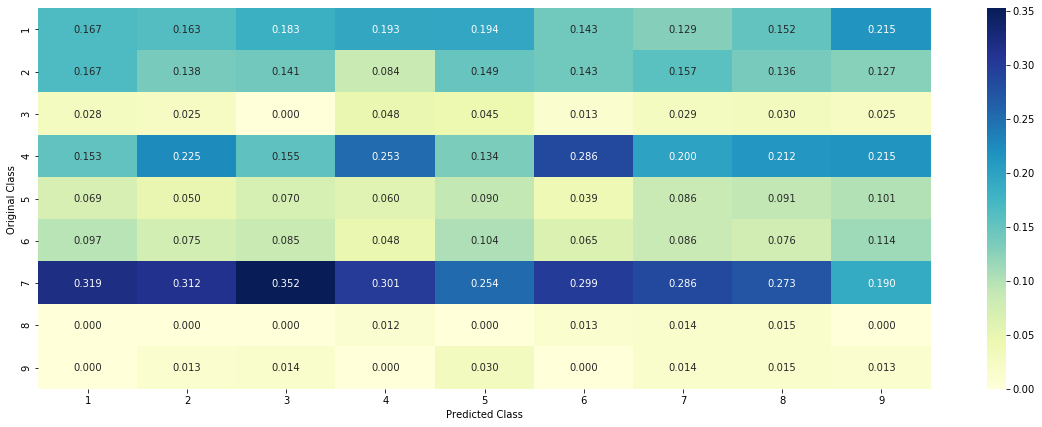

In [304]:
#Precision matrix

B =(C/C.sum(axis=0))

plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

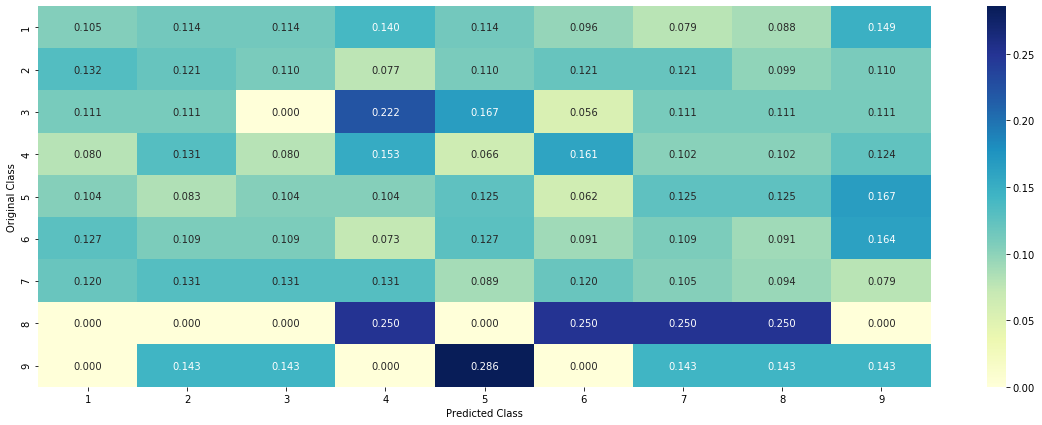

In [305]:
# Recall matrix

A =(((C.T)/(C.sum(axis=1))).T)

plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# preprocessing the data 

In [310]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

Number of Unique Genes : 230


## genes are categorical nature 
## we have 2 techniques to deal with it.

    ***One-hot encoding***
    ***Response Encoding*** (Mean imputation)


In [313]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [315]:
train_gene_feature_onehotCoding.shape

(2124, 229)

In [320]:
#column names after one-hot encoding for Gene column
#gene_vectorizer.get_feature_names()

### Now, lets also create Response encoding columns for Gene column

In [343]:
alpha = 1
feature = "Gene"
value_count = train_df[feature].value_counts()
gv_dict = dict()
for i, denominator in value_count.items():
    #print(i,denominator)
    vec = []
    # class range 1 - 9
    for k in range(1,10):
        cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
        vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        #print("Gene = ", i ,"class =" ,k," ",cls_cnt.shape[0],"vec :",vec )
    #print(100*'#')
    gv_dict[i]=vec
#return gv_dict
    #print(cls_cnt)

In [345]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):

    value_count = train_df[feature].value_counts()
    # like dictonary { feature : count } 
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append( (cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha) )

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [346]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [347]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [351]:
train_gene_feature_responseCoding[0]

array([0.10752688, 0.11827957, 0.10752688, 0.10752688, 0.10752688,
       0.10752688, 0.12903226, 0.10752688, 0.10752688])

#  question is how good is Gene column feature to predict my 9 classes. 
*  we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [353]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [358]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2475308302047712
For values of alpha =  0.0001 The log loss is: 1.2119785436672803
For values of alpha =  0.001 The log loss is: 1.2416532594711347
For values of alpha =  0.01 The log loss is: 1.364666643181691
For values of alpha =  0.1 The log loss is: 1.4674707651309258
For values of alpha =  1 The log loss is: 1.5022006197780025


In [360]:
cv_log_error_array

[1.2475308302047712,
 1.2119785436672803,
 1.2416532594711347,
 1.364666643181691,
 1.4674707651309258,
 1.5022006197780025]

In [361]:
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

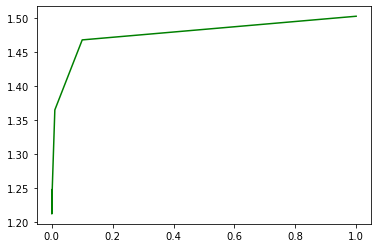

In [359]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

### annotate() function in the pyplot module (or annotate method of the Axes class) is used to draw an arrow connecting two points on the plot.

In [362]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.993558437006115
For values of best alpha =  0.0001 The cross validation log loss is: 1.2119785436672803
For values of best alpha =  0.0001 The test log loss is: 1.1896039707481354


* Log loss on Cross Validation Data using Random Model 2.522525704969488
* Log loss on Test Data using Random Model 2.4764028868826875

#### we definitely see some improvement hence the Gene column contributes to model accuracy 

# Evaluating Variation column

In [365]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0.0,FAM58A,Truncating_Mutations,1.0,cyclin dependent kinases cdks regulate variety...
1,1.0,CBL,W802*,2.0,abstract background non small cell lung cancer...
2,2.0,CBL,Q249E,2.0,abstract background non small cell lung cancer...
3,3.0,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4.0,CBL,L399V,4.0,oncogenic mutations monomeric casitas b lineag...


In [366]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1929
Truncating_Mutations    61
Amplification           48
Deletion                46
Fusions                 18
Overexpression           4
G12V                     4
Q61R                     3
E17K                     3
Q61L                     3
G12A                     2
Name: Variation, dtype: int64


In [367]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

# generate response encoding for the same.

In [369]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [370]:
train_variation_feature_responseCoding

array([[0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011],
       [0.12087912, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011],
       [0.10989011, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011],
       ...,
       [0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011],
       [0.12087912, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011],
       [0.10989011, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011]])

In [371]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [372]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7174306314753098
For values of alpha =  0.0001 The log loss is: 1.7092747431078554
For values of alpha =  0.001 The log loss is: 1.7121301170237329
For values of alpha =  0.01 The log loss is: 1.7232883050975352
For values of alpha =  0.1 The log loss is: 1.730996799734576
For values of alpha =  1 The log loss is: 1.7318860336850954


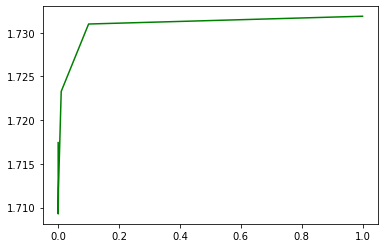

In [373]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

In [374]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6616440911704836
For values of best alpha =  0.0001 The cross validation log loss is: 1.7092747431078554
For values of best alpha =  0.0001 The test log loss is: 1.6913816832481996


* Log loss on Cross Validation Data using Random Model 2.522525704969488
* Log loss on Test Data using Random Model 2.4764028868826875

# Evaluating Text column

In [376]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [423]:
#dict_list[0]
'''
{'tumor': 7941,
             'suppressor': 1657,
             'p53': 12977,
             'dependent': 2163}
'''
# dict_list[0].get('suppressor')
# 1657
# number of times class i occur in dict_list[]

1657

In [418]:
train_df.head(5)

,ID,Gene,Variation,Class,TEXT
865,865.0,ERG,EWSR1-ERG_Fusion,7.0,sarcomas constitute aggressive adult childhood...
468,468.0,TP53,K291Q,1.0,tumor suppressor p53 dependent apoptosis thoug...
696,696.0,CDKN2B,Hypermethylation,4.0,multiple myeloma mm incurable plasma cell neop...
504,504.0,TP53,R282W,1.0,many p53 missense mutations possess dominant n...
1439,1439.0,SPOP,S119N,4.0,largest e3 ligase subfamily cul3 binds btb dom...


In [377]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                #print(word)
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [425]:
#get_text_responsecoding(train_df)

In [389]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
#stored elements in Compressed Sparse Row format
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
#train_text_feature_onehotCoding
# # getting all the feature names (words)
# before this line we follow the usual way 
#-----------------------------------------
# this part is new 
train_text_features= text_vectorizer.get_feature_names()
#train_text_features
# # train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
# # zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
'''
text_fea_dict = {word : count}
{'00': 2472,
 '000': 5703,
 '00000001': 6,
 '0000001': 4,
 '000001': 18,
 }
'''
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53511


In [388]:
result

,ID,Gene,Variation,Class,TEXT
0,0.0,FAM58A,Truncating_Mutations,1.0,cyclin dependent kinases cdks regulate variety...
1,1.0,CBL,W802*,2.0,abstract background non small cell lung cancer...
2,2.0,CBL,Q249E,2.0,abstract background non small cell lung cancer...
3,3.0,CBL,N454D,3.0,recent evidence demonstrated acquired uniparen...
4,4.0,CBL,L399V,4.0,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316.0,RUNX1,D171N,4.0,introduction myelodysplastic syndromes mds het...
3317,3317.0,RUNX1,A122*,1.0,introduction myelodysplastic syndromes mds het...
3318,3318.0,RUNX1,Fusions,1.0,runt related transcription factor 1 gene runx1...
3319,3319.0,RUNX1,R80C,4.0,runx1 aml1 gene frequent target chromosomal tr...


In [400]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    #cls_text
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list
total_dict = extract_dictionary_paddle(train_df)

In [396]:
# train_df[train_df['Class']==1]
'''
	ID	   Gene	 Variation	Class	TEXT
468	468.0	TP53	K291Q	1.0	    tumor suppressor p53 dependent apoptosis thoug...
504	504.0	TP53	R282W	1.0	    many p53 missense mutations possess dominant n...
'''


'\n\tID\t   Gene\t Variation\tClass\tTEXT\n468\t468.0\tTP53\tK291Q\t1.0\t    tumor suppressor p53 dependent apoptosis thoug...\n504\t504.0\tTP53\tR282W\t1.0\t    many p53 missense mutations possess dominant n...\n'

In [395]:
# cls_text = train_df[train_df['Class']==1]
# extract_dictionary_paddle(cls_text)
'''
'tumor': 7941,
'suppressor': 1657,
'p53': 12977
'''

"\n'tumor': 7941,\n'suppressor': 1657,\n'p53': 12977\n"

In [403]:
'''
text_fea_dict = {word : count}
{'00': 2472,
 '000': 5703,
 '00000001': 6,
 '0000001': 4,
 '000001': 18,
 }
'''
#train_text_features : Coontain the word part 

"\ntext_fea_dict = {word : count}\n{'00': 2472,\n '000': 5703,\n '00000001': 6,\n '0000001': 4,\n '000001': 18,\n }\n"

In [426]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [427]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [430]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [431]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [434]:
print(Counter(sorted_text_occur))

Counter({3: 5658, 4: 3561, 5: 2996, 6: 2818, 8: 2290, 7: 1716, 10: 1617, 9: 1584, 12: 1366, 13: 1121, 11: 975, 16: 894, 14: 841, 15: 804, 18: 769, 21: 588, 20: 582, 17: 529, 24: 517, 26: 510, 19: 444, 27: 405, 25: 399, 22: 393, 30: 392, 23: 365, 28: 332, 41: 326, 36: 297, 29: 283, 32: 276, 53: 259, 31: 247, 35: 244, 39: 243, 40: 234, 33: 234, 34: 226, 48: 213, 42: 212, 38: 209, 37: 207, 45: 194, 44: 192, 46: 187, 50: 174, 49: 158, 56: 148, 43: 148, 54: 146, 55: 145, 51: 135, 47: 135, 63: 134, 60: 133, 57: 127, 65: 126, 59: 126, 52: 121, 69: 119, 58: 117, 72: 116, 64: 116, 88: 106, 61: 98, 66: 94, 80: 93, 70: 92, 71: 91, 67: 91, 78: 88, 62: 87, 74: 83, 73: 83, 90: 78, 68: 78, 86: 74, 84: 74, 79: 73, 81: 72, 82: 71, 89: 70, 104: 69, 87: 69, 75: 69, 77: 68, 76: 68, 93: 66, 106: 64, 99: 63, 91: 62, 95: 61, 110: 60, 105: 59, 100: 59, 92: 59, 96: 58, 112: 55, 101: 55, 94: 55, 107: 54, 108: 53, 97: 53, 132: 50, 114: 49, 102: 49, 83: 49, 127: 48, 117: 47, 98: 47, 85: 47, 144: 46, 138: 45, 115:

In [ ]:
# Lets build the model with only text column

In [435]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2826609038221222
For values of alpha =  0.0001 The log loss is: 1.19281570383653
For values of alpha =  0.001 The log loss is: 1.2100591569745163
For values of alpha =  0.01 The log loss is: 1.3309655176730235
For values of alpha =  0.1 The log loss is: 1.4664180579796413
For values of alpha =  1 The log loss is: 1.6396588510407184


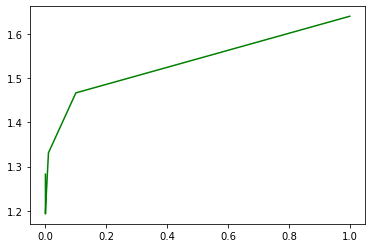

In [436]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

In [437]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.660442733142461
For values of best alpha =  0.0001 The cross validation log loss is: 1.19281570383653
For values of best alpha =  0.0001 The test log loss is: 1.2073481501140348


# Data prepration for Machine Learning models

In [439]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [440]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [441]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Combining all 3 features together
* THe next part combines the data 

In [444]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

# tocsr() : Saves in sparse matrix format 

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [445]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55697)
(number of data points * number of features) in test data =  (665, 55697)
(number of data points * number of features) in cross validation data = (532, 55697)


In [446]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

# Naive Bayes

In [451]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3154908204890614
for alpha = 0.0001
Log Loss : 1.3199217107943397
for alpha = 0.001
Log Loss : 1.3142090929661403
for alpha = 0.1
Log Loss : 1.3016827930531316
for alpha = 1
Log Loss : 1.3119557571811955
for alpha = 10
Log Loss : 1.4270109840595655
for alpha = 100
Log Loss : 1.4295583584866252
for alpha = 1000
Log Loss : 1.3758718318191048


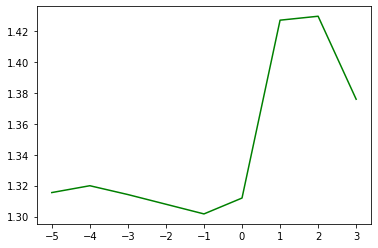

In [452]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

In [453]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8644079427482055
For values of best alpha =  0.1 The cross validation log loss is: 1.3016827930531316
For values of best alpha =  0.1 The test log loss is: 1.2653034319926084


Log Loss : 1.3016827930531316
Number of missclassified point : 0.40789473684210525


<ipython-input-440-e931cb640130>:7: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


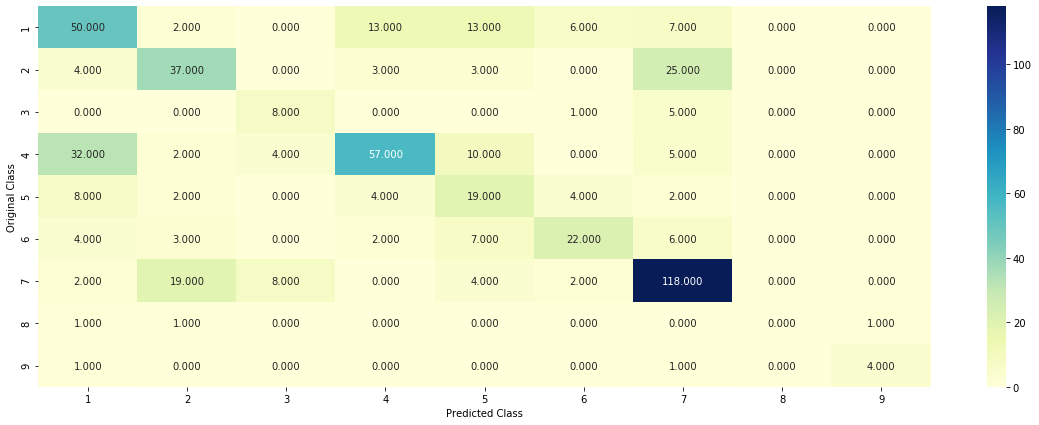

-------------------- Precision matrix (Columm Sum=1) --------------------


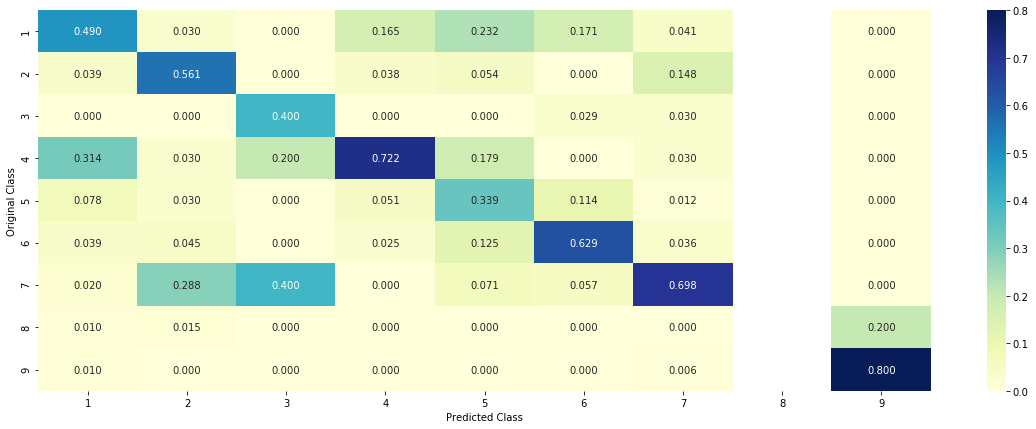

-------------------- Recall matrix (Row sum=1) --------------------


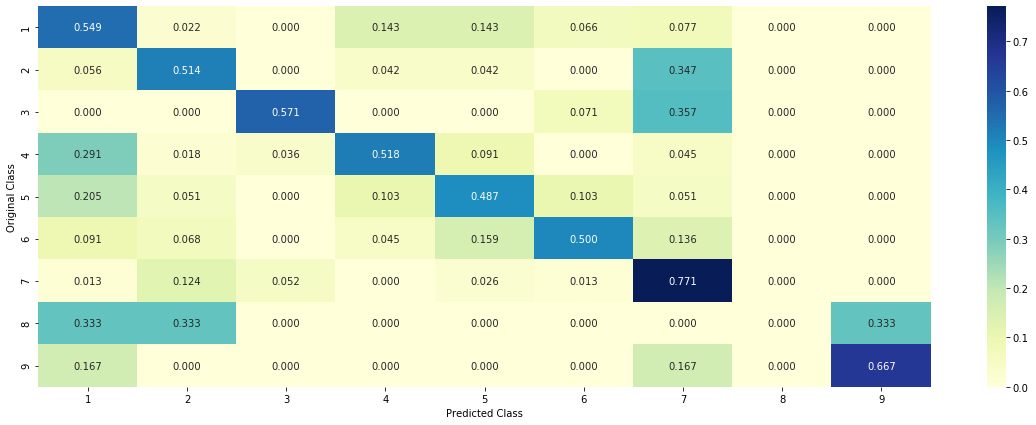

In [454]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### caliberated classifier is good for log loss and probabilistic model 